In [1]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib.gridspec import GridSpec

FACTOR = 1.2
SMALL_SIZE = 8 * FACTOR
MEDIUM_SIZE = 11 * FACTOR
BIGGER_SIZE = 14 * FACTOR

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
#plt.rc('figure', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('figure',autolayout=True)
plt.rc('lines', linewidth=2)
plt.rc('lines', markersize=7)

# fix rcParams for plotting
#plt.rcParams.update({'title.font.size': 14})
#plt.rcParams.update({'lines.linewidth': 2, 'lines.markersize': 10})


In [12]:
#data = pd.read_csv('../data/data-agg.csv')
data = pd.read_csv('../data/full-coin-data/coin data/analyses/df-time-agg.csv')

data['N_throws'] = data['N_start_heads_up'] + data['N_start_tails_up']
data['tails_tails'] = data['N_start_tails_up'] - data['tails_heads']
data['heads_tails'] = data['N_start_heads_up'] - data['heads_heads']
data['same_side'] = data['heads_heads'] + data['tails_tails']

# drop ingeborgR
data = data[data['person']!='ingeborgR'] # -> adds both a person and a coin (100 throws, can remove her)

data['diff_side'] = data['N_throws'] - data['same_side']

In [37]:
def deviance_analysis( data, formula, filename ):
    try : 
        results = sm.load(f'../models/{filename}.pickle')
    except FileNotFoundError:
        model = smf.glm(formula=formula, data=data, family=sm.families.Binomial())
        results = model.fit()
        results.save(f'../models/{filename}.pickle')
    
    dic = {}
    dic['formula'] = formula.split('~')[1]
    dic['deviance'] = results.deviance
    dic['aic'] = results.aic
    dic['df_residual'] = results.df_resid
    dic['df_model'] = results.df_model

    return dic, results


formula_cst = 'same_side+diff_side~1'
formula_person = 'same_side+diff_side~1+C(person)'
formula_coin_pers = 'same_side+diff_side~1+C(person)+C(coin)'
formula_nested = 'same_side+diff_side~1+C(person)+C(coin)+C(person):C(coin)'

results = []
dic_cst, results_cst = deviance_analysis(data, formula_cst, 'cst_glm')
results.append(dic_cst)
dic_person, results_person = deviance_analysis(data, formula_person, 'person_glm')
results.append(dic_person)
dic_coin_pers, results_coin_pers = deviance_analysis(data, formula_coin_pers, 'coin_pers_glm')
results.append(dic_coin_pers)
dic_nested, results_nested = deviance_analysis(data, formula_nested, 'nested')
results.append(dic_nested)

results_df = pd.DataFrame(results)
results_df['aic'] = results_df['aic'] - results_df['aic'].min()
print(results_df)



                                 formula     deviance         aic  \
0                                      1  3943.481439  173.973865   
1                            1+C(person)  3677.507574    0.000000   
2                    1+C(person)+C(coin)  3611.115584   17.608010   
3  1+C(person)+C(coin)+C(person):C(coin)  3460.032656  108.525082   

   df_residual  df_model  
0         3409         0  
1         3363        46  
2         3321        88  
3         3200       209  


In [38]:
#results_nested.summary()

In [42]:
def compare_lr_test( dic, dic_restricted ):
    res = {}
    res['tested_model'] = dic['formula']
    res['restricted_model'] = dic_restricted['formula'] 

    deviance_diff = dic_restricted['deviance'] - dic['deviance']
    df_diff = dic_restricted['df_residual'] - dic['df_residual']
    p_value = 1 - stats.chi2.cdf(deviance_diff, df_diff)
    res['p_value'] = p_value

    return res

print('Table for model comparison : ')
deviance_string = results_df.to_latex(index=False, 
                columns=["formula", "deviance", "aic", "df_model"], 
                header=["Model", "Deviance", "AIC", "Model DF"],
                formatters={"formula": lambda x: r'\texttt{'+x+r'}'},
                float_format="{:.2f}".format,
                caption="Model comparison for different models.",
                label="tab:model-comparison",
                position="htb",
                column_format="lccc")
caption_index = deviance_string.find(r'\caption')
deviance_string = deviance_string[:caption_index] + r'\centering' + '\n' + deviance_string[caption_index:]
print(deviance_string)

entries = []
entries.append( compare_lr_test( dic_person, dic_cst ) )
entries.append( compare_lr_test( dic_coin_pers, dic_person ) )
entries.append( compare_lr_test( dic_nested, dic_coin_pers ) )
table = pd.DataFrame(entries)

print('LLR test table : ')
llr_string = table.to_latex(index=False, 
                columns=['tested_model', 'restricted_model', 'p_value'], 
                header=['Tested model', 'Restricted model', '$p$-value'],
                formatters={"tested_model": lambda x: r'\texttt{'+x+r'}',
                            "restricted_model": lambda x: r'\texttt{'+x+r'}'},
                float_format="{:.2e}".format,
                caption="Likelihood ratio tests between models.",
                label="tab:llr-comparison",
                position="htb",
                column_format="llc")
caption_index = llr_string.find(r'\caption')
llr_string = llr_string[:caption_index] + r'\centering' + '\n' + llr_string[caption_index:]
print(llr_string)



Table for model comparison : 
\begin{table}[htb]
\centering
\caption{Model comparison for different models.}
\label{tab:model-comparison}
\begin{tabular}{lccc}
\toprule
Model & Deviance & AIC & Model DF \\
\midrule
\texttt{1} & 3943.48 & 173.97 & 0 \\
\texttt{1+C(person)} & 3677.51 & 0.00 & 46 \\
\texttt{1+C(person)+C(coin)} & 3611.12 & 17.61 & 88 \\
\texttt{1+C(person)+C(coin)+C(person):C(coin)} & 3460.03 & 108.53 & 209 \\
\bottomrule
\end{tabular}
\end{table}

LLR test table : 
\begin{table}[htb]
\centering
\caption{Likelihood ratio tests between models.}
\label{tab:llr-comparison}
\begin{tabular}{llc}
\toprule
Tested model & Restricted model & $p$-value \\
\midrule
\texttt{1+C(person)} & \texttt{1} & 0.00e+00 \\
\texttt{1+C(person)+C(coin)} & \texttt{1+C(person)} & 9.61e-03 \\
\texttt{1+C(person)+C(coin)+C(person):C(coin)} & \texttt{1+C(person)+C(coin)} & 3.32e-02 \\
\bottomrule
\end{tabular}
\end{table}



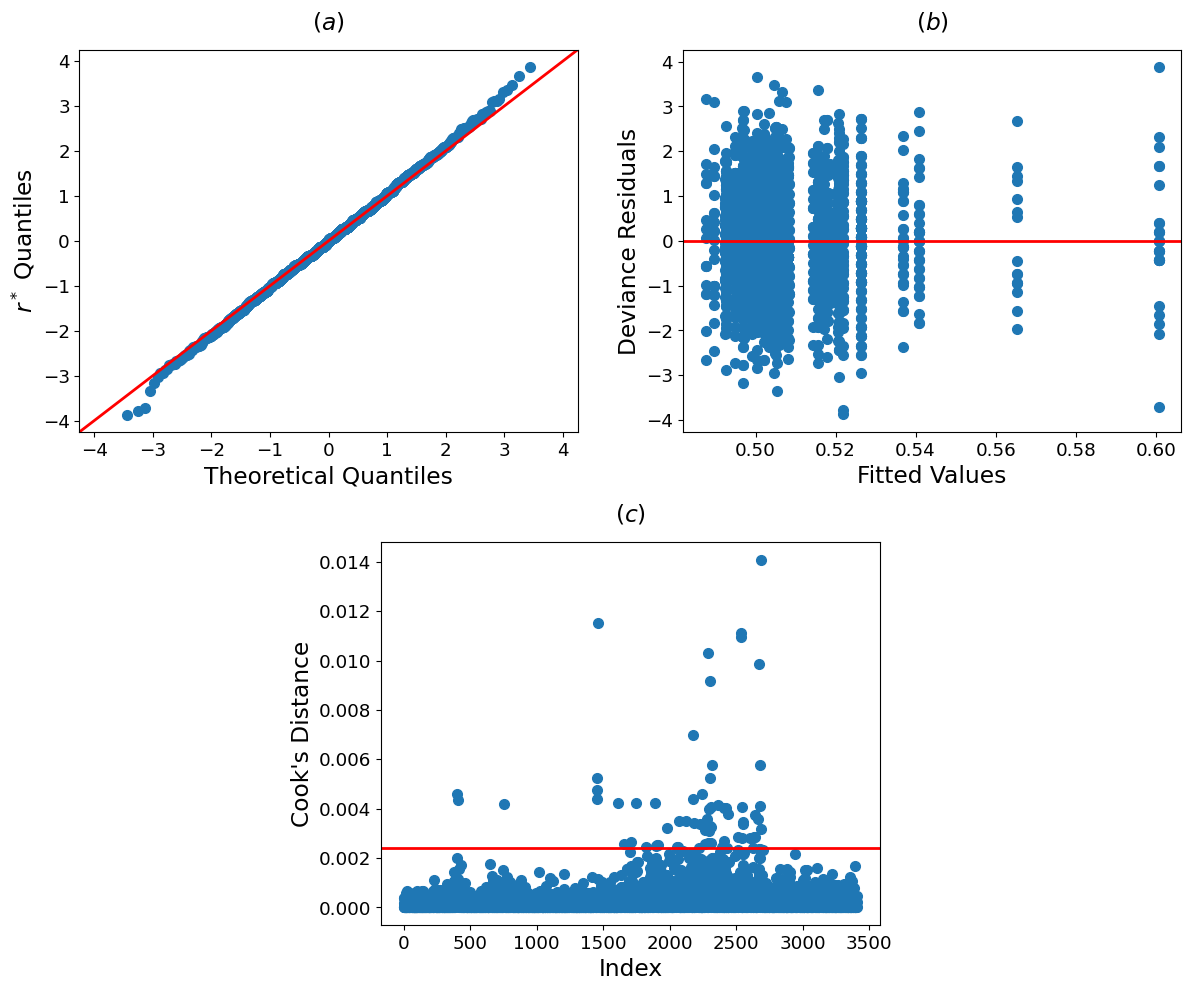

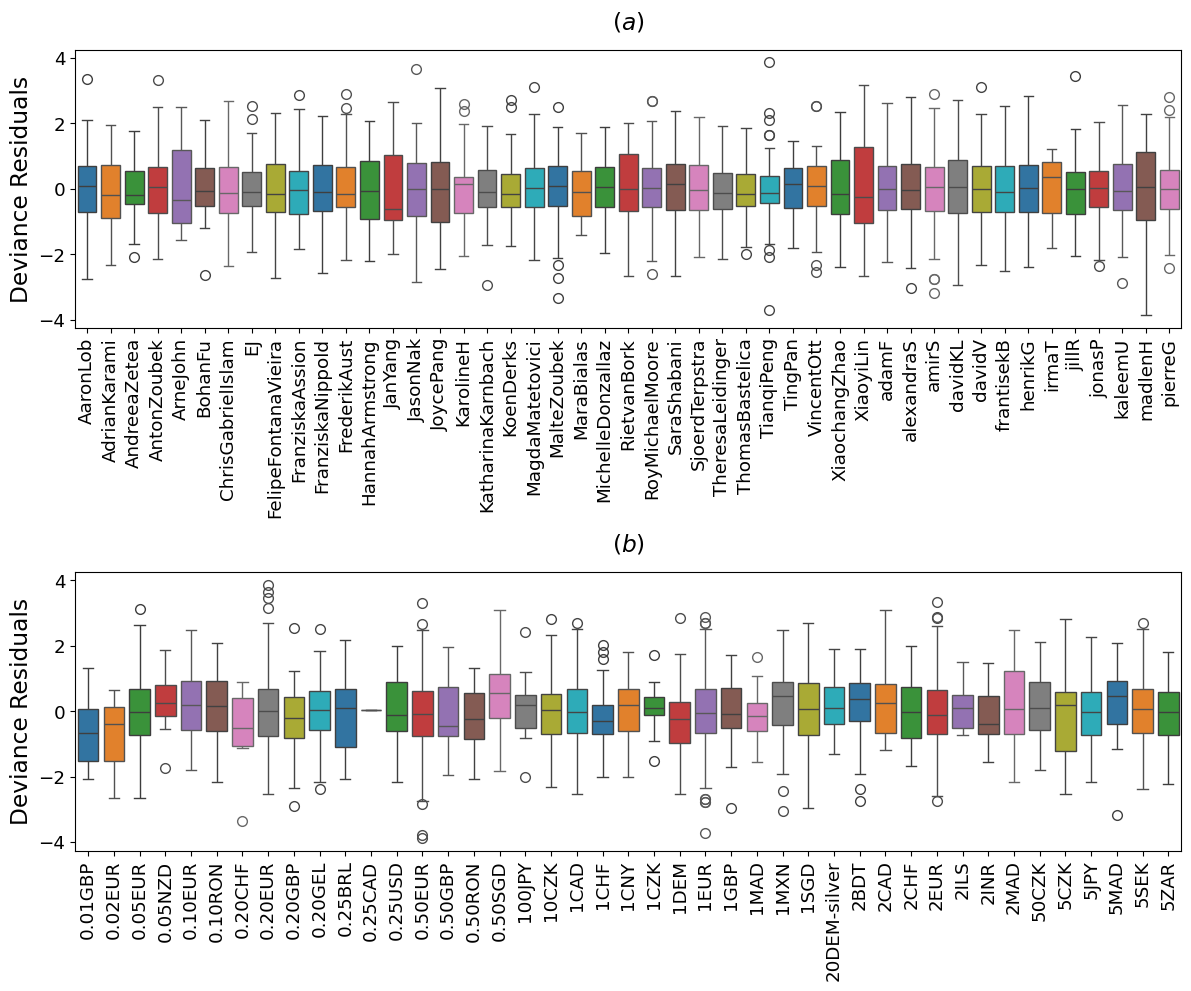

In [143]:
# can add plot of residuals vs fitted values/linear predictor or covariates
# do also as function of person and coin 
# Cook with davi threshold (8/(n-2p)) 

def influence_analysis( results, ax ):
    influence_inst = results.get_influence()
    leverage = influence_inst.hat_matrix_diag

    resid_dev = results.resid_deviance / np.sqrt(1-leverage)
    resid_pea = results.resid_pearson / np.sqrt(1-leverage)
    
    influence = {}
    influence['dav_resid'] = resid_dev + np.log( resid_pea / resid_dev ) / resid_dev
    influence['stud_pea_resid'] = influence_inst.resid_studentized
    influence['leverage'] = leverage
    influence['cooks_d'] = influence_inst.cooks_distance

    #sm.qqplot(influence['stud_pea_resid'], line ='45', ax=ax[0])
    sm.qqplot(influence['dav_resid'], line ='45', ax=ax[0])
    ax[0].set_ylabel('$r^*$ Quantiles')
    ax[0].set_title('$(a)$', pad=15)

    #influence_inst.plot_influence(size=20, ax=ax[2])
    #ax[2].set_title('$(c)$', pad=15)
    #ax[2].set_ylabel('Studentized Pearson Residuals')

    fitted = results_person.fittedvalues
    ax[1].scatter( fitted, resid_dev )
    ax[1].axhline(0, color='red')
    max_resid = max(np.abs(resid_dev))
    ax[1].set_ylim(-1.1*max_resid, 1.1*max_resid)
    ax[1].set_xlabel('Fitted Values')
    ax[1].set_ylabel('Deviance Residuals')
    ax[1].set_title('$(b)$', pad=15)

    # plot cooks distance as function of index
    threshold = 8 / (len(fitted) - 2*results_person.df_model)
    ax[2].scatter( range(len(influence['cooks_d'][0])), influence['cooks_d'][0] )
    ax[2].axhline(threshold, color='red')
    ax[2].set_xlabel('Index')
    ax[2].set_ylabel('Cook\'s Distance')
    ax[2].set_title('$(c)$', pad=15)

    return

def residual_vs_covariate( results, data, ax ):
    import seaborn as sb

    influence_inst = results.get_influence()
    leverage = influence_inst.hat_matrix_diag

    resid_dev = results.resid_deviance / np.sqrt(1-leverage)
    resid_pea = results.resid_pearson / np.sqrt(1-leverage)

    influence = {}
    influence['dav_resid'] = resid_dev + np.log( resid_pea / resid_dev ) / resid_dev
    influence['stud_pea_resid'] = influence_inst.resid_studentized
    
    influence['leverage'] = leverage
    influence['cooks_d'] = influence_inst.cooks_distance

    for i, (col,lab) in enumerate( zip( ['person', 'coin'], ['a','b'] ) ):
        df_resid = pd.DataFrame({'dav_resid': influence['dav_resid'], col: data[col]})
        grouped_resid = df_resid.groupby(col)
        
        xticks = []
        for name, group in grouped_resid:
            sb.boxplot(x=group[col], y=group['dav_resid'], ax=ax[i])
            #ax[k].scatter(group[col], group['dav_resid'])
            xticks.append(name)
        
        ax[i].set_xlabel('')
        ax[i].set_ylabel('Deviance Residuals')
        ax[i].set_title(f'$({lab})$', pad=15)
        ax[i].set_xticks(xticks)
        ax[i].set_xticklabels(xticks, rotation=90)

    return



fig = plt.figure(figsize=(12, 10), layout='tight')

gs = GridSpec(2, 4, figure=fig, )
ax1 = fig.add_subplot(gs[0,0:2])
ax2 = fig.add_subplot(gs[0,2:])
ax3 = fig.add_subplot(gs[1,1:-1])

influence_analysis( results_person, [ax1,ax2,ax3] )
plt.tight_layout()
plt.savefig('../figures/GLM_diagnostics.png', dpi=300)


fig, ax = plt.subplots(2, 1, figsize=(12, 10))
residual_vs_covariate( results_person, data, ax )
plt.tight_layout()
plt.savefig('../figures/dev_resid_vs_covariates.png', dpi=300)




In [28]:
# import data
data = pd.read_csv('../data/full-coin-data/coin data/analyses/data-long.csv' )#, nrows=100000)
# print number of rows and columns
print(data.shape)
# print type of data
# if toss_start = toss_end, set new column same_side = 1
data['same_side'] = 0
data['same_side'] = np.where(data['toss_start'] == data['toss_end'], 1, 0)
print(data.head())
print(data.dtypes)




(350757, 7)
       person          coin   dataset  sequence_id  toss_id toss_start  \
0  frantisekB  20DEM-silver  Marathon            1        1          t   
1  frantisekB  20DEM-silver  Marathon            1        2          t   
2  frantisekB  20DEM-silver  Marathon            1        3          t   
3  frantisekB  20DEM-silver  Marathon            1        4          h   
4  frantisekB  20DEM-silver  Marathon            1        5          t   

  toss_end  same_side  
0        t          1  
1        t          1  
2        h          0  
3        t          0  
4        h          0  
person         object
coin           object
dataset        object
sequence_id     int64
toss_id         int64
toss_start     object
toss_end       object
same_side       int64
dtype: object


KeyboardInterrupt: 

In [22]:

formula = 'same_side ~ 1 + C(coin) + C(person)'
mod1 = smf.glm(formula=formula, data=data, family=sm.families.Binomial()).fit()
print(mod1.summary())
# could play with link


                 Generalized Linear Model Regression Results                  
Dep. Variable:              same_side   No. Observations:               100000
Model:                            GLM   Df Residuals:                    99968
Model Family:                Binomial   Df Model:                           31
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -69268.
Date:                Mon, 23 Dec 2024   Deviance:                   1.3854e+05
Time:                        16:22:05   Pearson chi2:                 1.00e+05
No. Iterations:                   100   Pseudo R-squ. (CS):          0.0006420
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [12]:
family = sm.families.Binomial( ) 
glm = sm.GLM( data['same_side'], data[['person','coin']], family=family)
res = glm.fit()
print(res.summary())

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).